In [1]:
import numpy as np
from dobbel import dobbellogger
from help_functies import *
from calibrator import calibrate
import matplotlib.pyplot as plt
dob = dobbellogger()

In [2]:
cali = calibrate(dob)
gyro_bias = cali['gyro bias']
acc_bias = cali['acc bias']
acc_std = cali['acc std']
gyro_std = cali['gyro std']

Leg de dobbelsteen met nummer  1  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  2  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf
Leg de dobbelsteen met nummer  3  boven
wacht 3 secondes
Logging data for 2s
Done! The data is located in self.datadf


In [14]:
dob.connect()
dob.log(5, 100, 4, 2000)
dob.download()
data = dob.datadf

Logging data for 5s
Done! The data is located in self.datadf


In [15]:
# Deze code niet vaker dan 1 keer uitvoeren!
data = remove_nan(data)
data = rotate_data(data)

data['x_gyro'] = data['x_gyro'] - gyro_bias[0]
data['y_gyro'] = data['y_gyro'] - gyro_bias[1]
data['z_gyro'] = data['z_gyro'] - gyro_bias[2]
data['x_acc'] = data['x_acc'] - acc_bias[0]
data['y_acc'] = data['y_acc'] - acc_bias[1]
data['z_acc'] = data['z_acc'] - acc_bias[2]

In [16]:
data.head(1000)

,timestamp,x_acc,y_acc,z_acc,x_gyro,y_gyro,z_gyro
0,0.0,-0.020741,-0.034873,1.018865,0.121451,-0.208874,-0.122897
1,10.0,-0.016242,-0.033286,1.025335,0.399078,-0.147899,-0.368846
2,21.0,-0.008769,-0.029990,1.022120,0.139479,-0.025947,0.048623
3,29.0,-0.004956,-0.028648,1.022066,-0.032041,-0.086923,0.066650
4,40.0,-0.003678,-0.031821,1.025143,0.139479,0.035028,0.048623
...,...,...,...,...,...,...,...
503,4887.0,-0.010035,-0.033530,1.026592,0.002494,-0.019850,0.024002
504,4888.0,-0.010025,-0.033591,1.026600,0.006332,-0.025947,0.019263
505,4897.0,-0.009940,-0.034141,1.026669,-0.041055,-0.086923,-0.019110
506,4907.0,-0.009524,-0.033897,1.027320,-0.032041,-0.147899,0.066650


In [17]:
y11 = np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]])
gb = y11 / np.linalg.norm(y11)
gn = np.array([0, 0, 1])
mn = np.array([1, 0, 0])
mb = np.array([1, 0, 0])
mb = np.cross(gb, np.cross(np.array([1,1,1]) / np.linalg.norm(np.array([1,1,1])), gb))

A = - np.matmul(left_quat_mul(np.array([0, *gn])), right_quat_mul(np.array([0, *gb]))) - np.matmul(left_quat_mul(np.array([0, *mn])), right_quat_mul(np.array([0, *mb])))

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(A)

# Eigenvalues are sorted in ascending order by np.linalg.eigh, 
# and the corresponding eigenvectors are columns of 'eigenvectors'
max_eigenvalue_index = np.argmax(eigenvalues)
max_eigenvector = eigenvectors[:, max_eigenvalue_index]

In [18]:
q11 = max_eigenvector

In [19]:
print(rotate_vector(np.array([data['x_acc'][0], data['y_acc'][0], data['z_acc'][0]]), q11))

[-6.59194921e-17 -3.46944695e-18  1.01967236e+00]


In [20]:
q = np.reshape(q11, 4)
q_list = [q]


for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    gyro_measurement = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]])
    omega = gyro_measurement
    expq_omega = expq(omega, 0.5 * dt * np.pi / 180)
    q = quat_mul(q, expq_omega)
    q_list.append(q)

    

In [21]:
print(q_list[0], q_list[-1])

[-0.92243544  0.01185638 -0.01598245  0.38563824] [-0.92245519  0.01220543 -0.01558229  0.38559648]


In [22]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

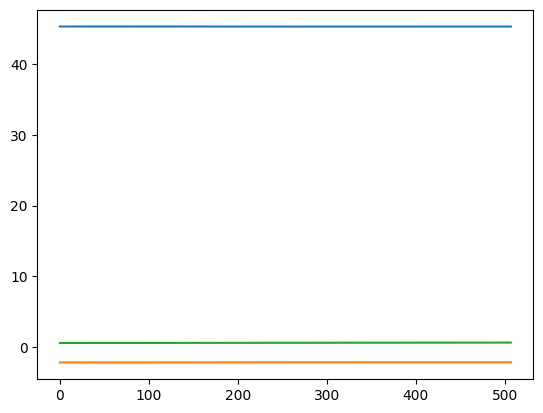

In [23]:
plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)

In [42]:
def Somega(omega):
    x, y, z = np.reshape(omega, 3)
    out = np.array([
        [0,-x,-y,-z],
        [x,0,x,-y],
        [y,-z,0,x],
        [z,y,-x,0]
    ])
    return out

def Sq(q):
    q0, q1, q2, q3 = np.reshape(q, 4)
    out = np.array([
        [-q1,-q2,-q3],
        [q0,-q3,q2],
        [q3,q0,-q1],
        [-q2,q1,q0]
    ])
    return out

In [43]:
q = np.reshape(q11, (4, 1))
q_list = [q]
I4 = np.array([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,0],
    [0,0,0,1]
])

for i in range(1, len(data['timestamp'])):
    dt = (data['timestamp'][i] - data['timestamp'][i - 1]) / 1000
    omega = np.array([data['x_gyro'][i], data['y_gyro'][i], data['z_gyro'][i]]) * np.pi / 180
    q = np.matmul(I4 + 0.5 * Somega(omega) * dt, q) + 0.5 * dt * np.matmul(Sq(q), np.reshape(omega, (3, 1)))
    q = np.reshape(q, (4, 1))
    q_list.append(q)

    

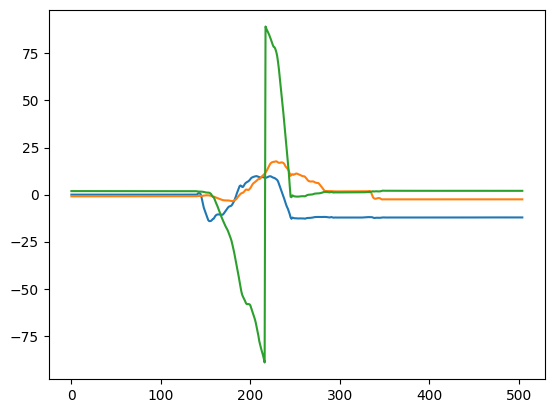

In [44]:
euler_x = []
euler_y = []
euler_z = []

for q, timestamp in zip(q_list, data['timestamp']):
    q = np.reshape(q, 4)
    euler = quat_to_euler(q) * 180 / np.pi
    euler_x.append(euler[0])
    euler_y.append(euler[1])
    euler_z.append(euler[2])

plt.plot(euler_x)
plt.plot(euler_y)
plt.plot(euler_z)
plt.show()